## 掩码向前变形算法

In [111]:
import math
import numpy as np
import cv2
ORI_DATA_MASS_MAX_DIAMETER = 1200
MAX_POINT = 16
MIN_AREA = 100
LARGE_THRESHOLD_AREA = 5000
DATA_RESIZE = 0.5
def _interactive_image_warp_multi_point(image, r_list, c_list, m_list, st_list):
    '''
    同时计算多个位移向量的前向变形映射
    '''
    for r, c, m, st in zip(r_list, c_list, m_list, st_list):
        img_y, img_x = np.mgrid[0:image.shape[0], 0:image.shape[1]].astype(np.float32)
        m = np.array(m, np.float32)
        p_in_ring = []
        c_x = c[1]
        c_y = c[0]
        for i in range(max(c_y - r, 0), min(c_y + r, image.shape[0])):
            for j in range(max(c_x - r, 0), min(c_x + r, image.shape[1])):
                if np.sqrt((i - c_y) ** 2 + (j - c_x) ** 2) <= r:
                    p_in_ring.append([i, j])
        p_in_ring = np.array(p_in_ring, dtype=np.float32)
        m = m[np.newaxis, ...]
        c = np.array([c], np.float32)
        s1 = (r ** 2 - np.sum((p_in_ring - c) ** 2, axis=-1))
        s1 = s1[..., np.newaxis]
        s2 = np.sum((m - c) ** 2, axis=-1)
        u = p_in_ring - ((s1 / (s1 + s2 * (100/st))) ** 2) * (m - c)

        for p_yx, u_yx in zip(p_in_ring, u):
            img_x[int(p_yx[0]), int(p_yx[1])] = u_yx[1]
            img_y[int(p_yx[0]), int(p_yx[1])] = u_yx[0]
        image = cv2.remap(image, img_x, img_y, cv2.INTER_CUBIC) # INTER_NEAREST
    return image

def _get_line_point(p1, p2, d, out = False):
    '''
    获取某个方向上的点
    p1: (h, w)
    p2: (h, w)
    d: 获取的点到p1(out == False)或p2(out == True)的距离的距离
    out: 指定获取的点在p1和p2之间(False), 在p1->p2方向上且越过p2(True)
    '''
    h = p2[0] - p1[0]
    w = p2[1] - p1[1]
    pd = math.sqrt(h ** 2 + w ** 2)
    ch = int(h * d / pd)
    cw = int(w * d / pd)
#     print(ch, cw)

    if out:
        p = np.array([p2[0] + ch, p2[1] + cw])
    else:
        p = np.array([p1[0] + ch, p1[1] + cw])
    return p

def forward_transform_multi_point(image, mask, point_num = 4, st = 20):
    '''
    多点向前变形算法
    image: numpy.array, type: uint8, shape:(h, w, 3), range: 0~255
    mask: numpy.array, type: uint8, shape:(h, w), range: 0或255
    point_num: int, 指定选择多少个点（在边界上均匀选择）, range: 1~16（建议范围，太多的话，小目标会出问题）
    st: int, 参考美图秀秀液化瘦脸功能的硬度参数（根据自己的图像进行适当调整）
    '''
    contours, _ = cv2.findContours((mask > 0).astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in contours if cv2.contourArea(contour) >= MIN_AREA]
    if len(contours) == 0:
        return None, None
    contour_idx_list = [i for i in range(len(contours))]
    contour_idx = np.random.choice(contour_idx_list)
    contour = contours[contour_idx]

    area = cv2.contourArea(contour)
    r = math.sqrt(area / math.pi)

    contour_point_num = len(contour)
    point_idx_list = [int(i * contour_point_num / MAX_POINT) for i in range(MAX_POINT)]

    point_idx_list = np.random.choice(point_idx_list, replace=False, size=point_num)
    point_list = []
    for point_idx in point_idx_list:
        point_list.append((contour[point_idx][0][1], contour[point_idx][0][0]))

    x_center, y_center = contour.mean(axis=(0, 1))
    x_center = int(x_center)
    y_center = int(y_center)
    r = int(r)
    # TODO: 拖动距离随机，这里需要根据实际情况设置最大最小值
    
    if area < LARGE_THRESHOLD_AREA:
        large = True
    else:
        large = np.random.choice([True, False])

    if large:
        p_list = []
        d = np.random.randint(r // 3, r + 1)
        for point in point_list:
            point_out = _get_line_point((y_center, x_center), point, d, out=True)
            point_out[0] = min(image.shape[0], point_out[0])
            point_out[1] = min(image.shape[1], point_out[1])
            p_list.append(point_out)
    else:
        p_list = []
        d = np.random.randint(r // 3, 2 * r // 3)
        for point in point_list:
            point_in = _get_line_point(point, (y_center, x_center), d, out=False)
            point_in[0] = min(image.shape[0], point_in[0])
            point_in[1] = min(image.shape[1], point_in[1])
            p_list.append(point_in)
    r_list = [r for _ in range(point_num)]
    st_list = [st for _ in range(point_num)]
    image = _interactive_image_warp_multi_point(image, r_list, point_list, p_list, st_list)
    mask = _interactive_image_warp_multi_point(mask, r_list, point_list, p_list, st_list)
    mask[mask > 127] = 255
    mask[mask <= 127] = 0
    return image, mask




255
uint8
uint8
uint8
uint8


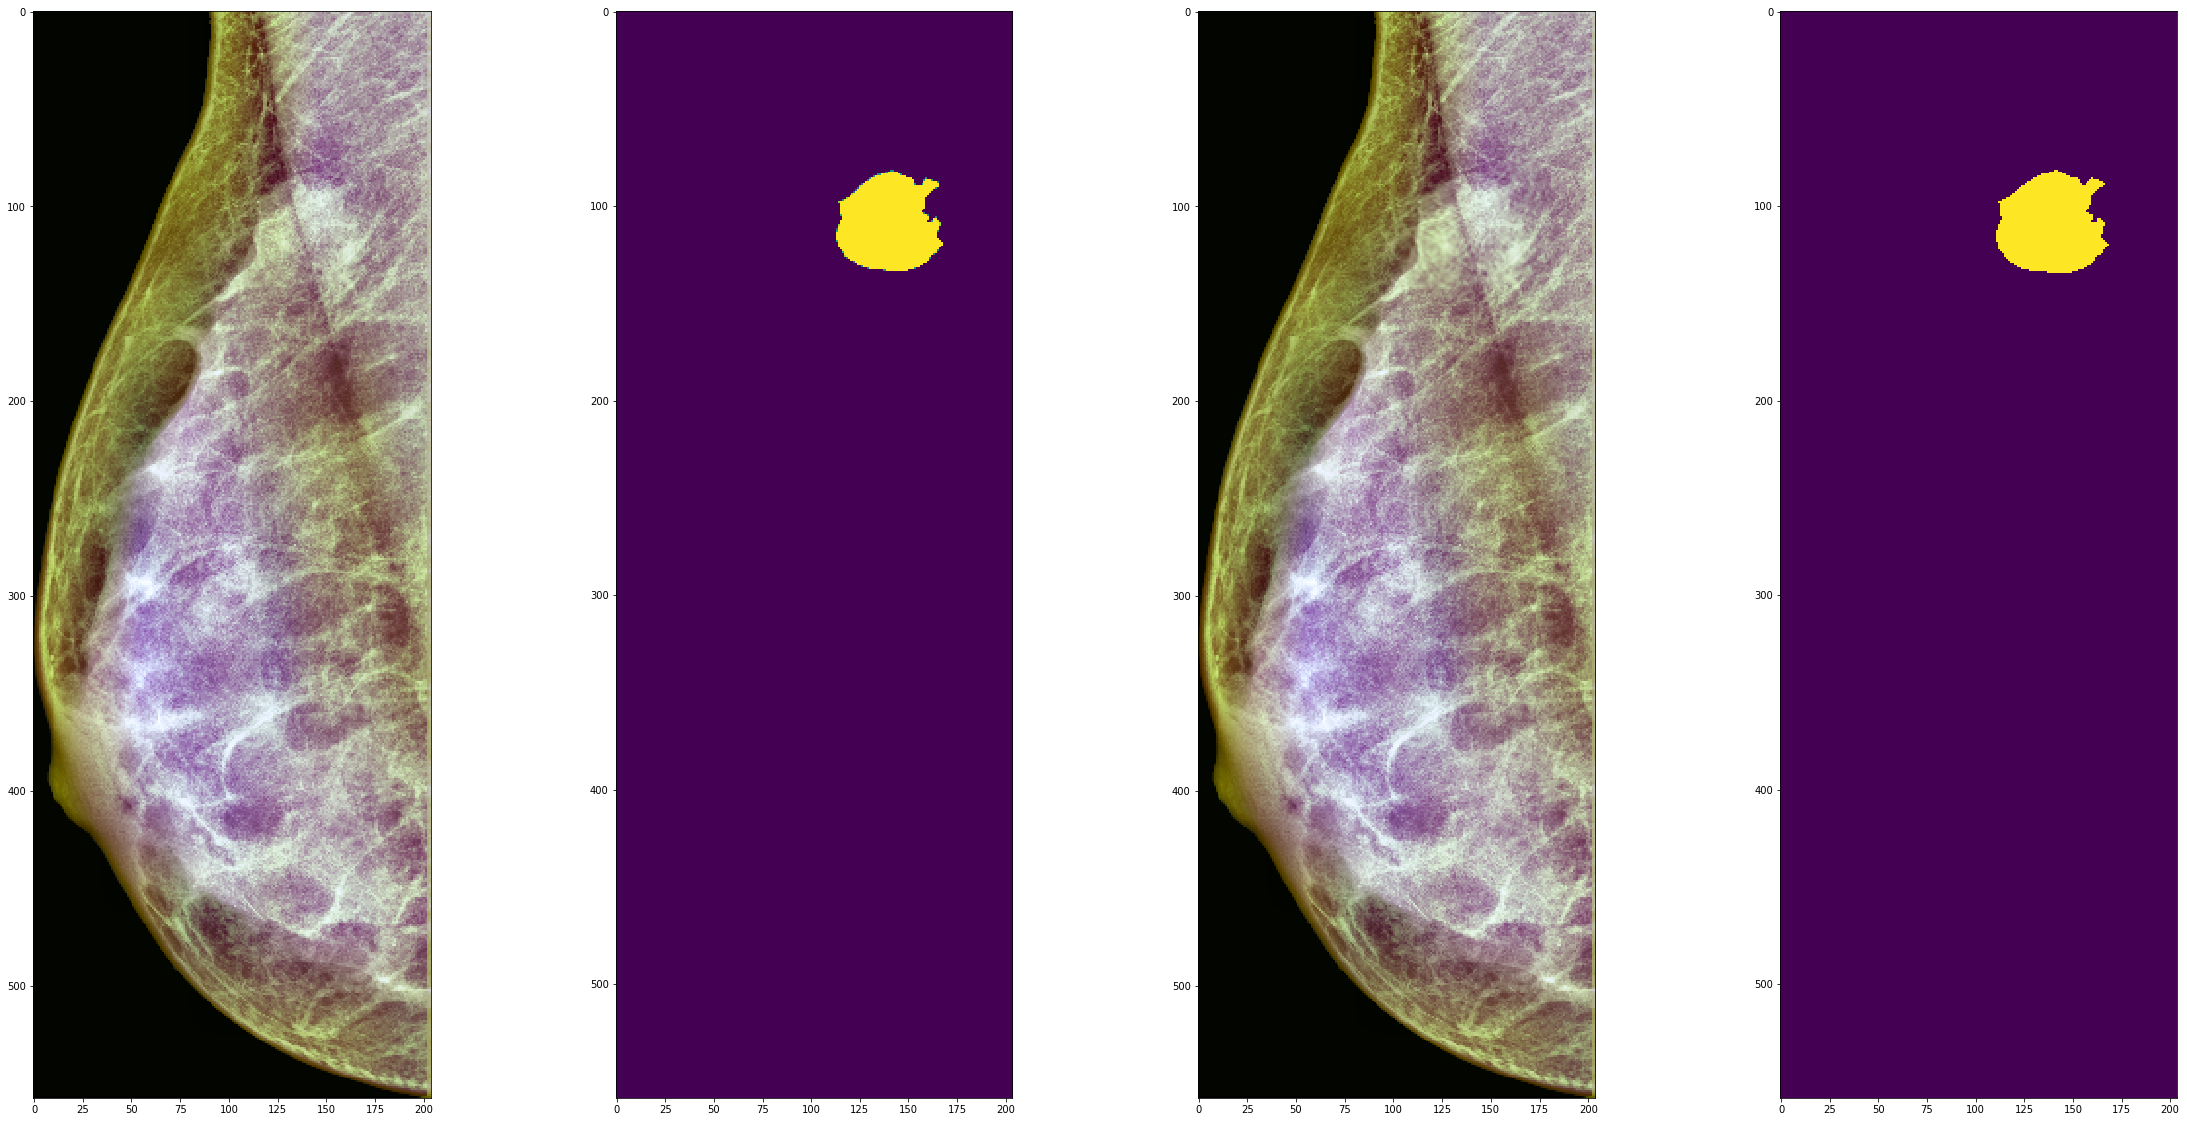

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

pid = '50994273'
image_dir = '/mnt/data/wb/inbreast_org/Mass/images'
mask_dir = '/mnt/data/wb/inbreast_org/Mass/mask'
mask_path = mask_dir + '/' + pid + '.npy'
image_path = image_dir + '/' + pid + '.npy'

image = np.load(image_path)
mask = np.load(mask_path).astype(np.uint8)
image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))
mask = cv2.resize(mask, (mask.shape[1] // 4, mask.shape[0] // 4))
print(np.max(mask))
plt.figure(figsize=(40,20))
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
plt.imshow(mask)
np.random.seed(9527)
print(image.dtype)
print(mask.dtype)
image_ft, mask_ft = forward_transform_multi_point(deepcopy(image), deepcopy(mask), point_num=8, st=20)
print(image_ft.dtype)
print(mask_ft.dtype)
plt.subplot(143)
plt.imshow(image_ft)
plt.subplot(144)
plt.imshow(mask_ft)